In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn import model_selection, metrics, dummy

import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

# Chargement des données

In [3]:
import pickle

with open("./data/pickle", 'rb') as f:
    data_X, data_Y = pickle.load(f)

In [4]:
# 0 pour les données sans star, 1 pour energystar
data_X = data_X[0]
data_Y = data_Y[0]

## Liste des colonnes utilisables

In [5]:
col_num = list(data_X.select_dtypes(include=['float', 'int', 'uint8']).columns)

# Prédiction simple

Pas de sélection, juste pour observer différents algos en CV (dont leur stabilité)

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from xgboost import XGBRegressor

In [7]:
def launch_kfold(model, X, y, splits=8, silence=False):
    kf = KFold(n_splits=splits)
    score_final = {'R2':0, 'RMSE':0, 'MAE':0}
    
    donnees_min = {'R2':1, 'iloc':None, 'pred':None}
    donnees_max = {'R2':-1, 'iloc':None, 'pred':None}

    for train, test in kf.split(X):
        # Entraînement
        model.fit(X.iloc[train], y.iloc[train])

        # Prédiction sur le jeu de test
        y_pred = model.predict(X.iloc[test])

        y_test = y.iloc[test]

        # Evaluate
        score = metrics.r2_score(y_test, y_pred)
        if not silence:
            print('R2 : ', score)
        score_final['R2'] += abs(score)
        
        if score < donnees_min['R2']:
            donnees_min['R2'] = score
            donnees_min['iloc'] = test.copy()
            donnees_min['pred'] = y_pred.copy()
        
        if score > donnees_max['R2']:
            donnees_max['R2'] = score
            donnees_max['iloc'] = test.copy()
            donnees_max['pred'] = y_pred.copy()

        score = metrics.mean_squared_error(y_test, y_pred, squared=True)
        score_final['RMSE'] += score

        score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
        score_final['MAE'] += score

    if not silence:
        for k, score in score_final.items():
            print('Score {} final : {}'.format(k, score/kf.get_n_splits()))
    
    return donnees_max, donnees_min

### Partie pour detecter les outliers réguliers
aka les lignes qui ne sont jamais bien prédites

In [8]:
def get_outliers(data_test, data_pred, outliers={}, step=0, limit=20):
    data_pred = pd.Series(data_pred, index=data_test.index).rename('Pred')

    compare_result = pd.concat([data_test.rename('Test'), data_pred], axis=1)
    compare_result['Diff'] = (compare_result['Test'] - compare_result['Pred']).abs()
    compare_result = compare_result.sort_values(by='Diff', ascending=False)
    
    for i in compare_result.head(limit).index:
        if i not in outliers:
            outliers[i] = 1-step
        else:
            outliers[i] += 1-step
    
    return outliers

In [9]:
outliers = {}

In [10]:
'''
for _ in range(50):
    idx = np.random.permutation(data_X.index)
    data_X = data_X.reindex(idx)
    data_Y = data_Y.reindex(idx)

    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)
    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)
    print(donnees_min['R2'])
    if donnees_min['R2'] < 0.6 :
        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)
'''

"\nfor _ in range(50):\n    idx = np.random.permutation(data_X.index)\n    data_X = data_X.reindex(idx)\n    data_Y = data_Y.reindex(idx)\n\n    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)\n    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)\n    print(donnees_min['R2'])\n    if donnees_min['R2'] < 0.6 :\n        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)\n"

In [11]:
# pd.DataFrame(outliers.items()).sort_values(by=1, ascending=False).head(20)

Suppression de ces valeurs

In [12]:
for i in []:#[304, 426, 3206]:
    data_X = data_X.drop(index=i)
    data_Y = data_Y.drop(index=i)

## Test de différents regressors

In [13]:
print('KFold avec DummyRegressor :')
dum = dummy.DummyRegressor(strategy='median')
launch_kfold(dum, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec Lasso :')
regr = MultiTaskLassoCV(cv=5)
launch_kfold(regr, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec XGBoost :')
xgbreg = XGBRegressor()
launch_kfold(xgbreg, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec RandomForest :')
regr = RandomForestRegressor(max_depth=50)
donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y)

KFold avec DummyRegressor :
R2 :  -0.0006305968918269844
R2 :  -0.02414595349473103
R2 :  -0.013291718042331202
R2 :  -0.02753348852246784
R2 :  -0.022426432226211324
R2 :  -0.004867872959013253
R2 :  -0.005068166328827561
R2 :  -0.015843178027180493
Score R2 final : 0.014225925811573711
Score RMSE final : 1.799637349112898
Score MAE final : 1.062985429748432



 KFold avec Lasso :
R2 :  0.7310528006529281
R2 :  0.7804099782444965
R2 :  0.7037299246046487
R2 :  0.7115642486989961
R2 :  0.6905565990404234
R2 :  0.7206011338427772
R2 :  0.7168374220846983
R2 :  0.551280893816738
Score R2 final : 0.7007541251232134
Score RMSE final : 0.5234171534470572
Score MAE final : 0.5535958836546407



 KFold avec XGBoost :
R2 :  0.7236014617981319
R2 :  0.7702018948918607
R2 :  0.7407308333197367
R2 :  0.6795575011413629
R2 :  0.6981391234297712
R2 :  0.71836128805779
R2 :  0.7233334712355277
R2 :  0.5979321804844491
Score R2 final : 0.7064822192948288
Score RMSE final : 0.5148963937757686
Score MA

## Affichage des features importance

In [14]:
def get_features_importance(model, X, y, plot=False):
    model.fit(X, y)
    importance = model.feature_importances_

    list_col = X.columns.to_list()
    list_features = []
    for i, v in pd.Series(importance).sort_values(ascending=False).items():
        list_features.append([list_col[i],v])
    
    list_features = pd.DataFrame(list_features, columns=['Nom', 'Value'])
    
    if plot:
        list_features.head(20).plot.barh(x='Nom', y='Value', figsize=(7,7))
    
    return list_features

,Nom,Value
0,Gas,0.128155
1,PropertyGFABuilding(s),0.092152
2,Type_Supermarket / grocery store,0.063200
3,Type_Hospital (general medical & surgical),0.061898
4,Steam,0.059457
...,...,...
59,Type_Bank branch,0.000624
60,CouncilDistrictCode_4,0.000460
61,Type_Financial office,0.000334
62,Type_Social/meeting hall,0.000000


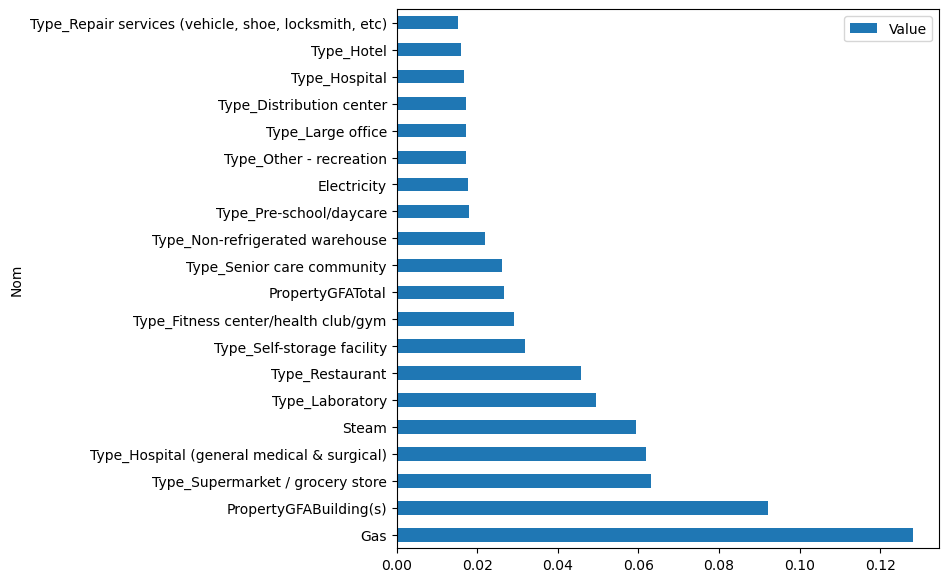

In [15]:
model = RandomForestRegressor(max_depth=30)
model = XGBRegressor()

get_features_importance(model, data_X[col_num], data_Y['CO2_Y'], True)

# GridSearch sur plusieurs algos

In [16]:
TARGET = 'Energy_Y' #'Energy_Y', 'CO2_Y'

In [17]:
from sklearn.model_selection import GridSearchCV
import time

list_models = []

def grid_search_cv_models(X, y, models, params):
    global list_models
    best_score = 0
    best_model = None
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

    for model, model_params in zip(models, params):
        gs = GridSearchCV(model, model_params, cv=5, error_score='raise', refit='r2', scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        
        # Entraîner le modèle sur les données X et y
        gs.fit(X_train, y_train)
        
        print("\n"*5, str(gs.best_estimator_), '\n')
        
        nom_estimator = str(gs.best_estimator_)
        
        list_models.append({"name":nom_estimator[:nom_estimator.index('(')], "clf":gs.best_estimator_})
        
        tab_cv_result = pd.DataFrame(gs.cv_results_)
        
        print(tab_cv_result[['mean_fit_time', 'mean_score_time', 'mean_test_r2']]) # 'params', 
        
        tab_cv_result = tab_cv_result.loc[tab_cv_result['rank_test_r2']==1]
        
        print("Temps d'entrainement : ", tab_cv_result['mean_fit_time'].to_list()[0])
        print("Temps de prédiction : ", tab_cv_result['mean_score_time'].to_list()[0])
        
        for n, m in [('R2', 'r2'), ('RMSE', 'neg_root_mean_squared_error'), ('MAE', 'neg_mean_absolute_error')]:
            mean = tab_cv_result['mean_test_'+m].to_list()[0]
            std = tab_cv_result['std_test_'+m].to_list()[0]
            
            if n!='R2':
                mean = -mean
                
            print("Score {} : {:.4f} Deviation : {:.4f}".format(n, mean, std))
        
        
        #print(tab_cv_result.columns)
        print('\nTest sur les données restantes :')
        
        start_time = time.time()
        trained_estimator = gs.best_estimator_.fit(X_train, y_train)
        print("Temps d'entrainement : ", time.time() - start_time)
        
        start_time = time.time()
        y_pred = trained_estimator.predict(X_test)
        print("Temps de prédiction : ", time.time() - start_time)
        
        for n, m in [('R2', metrics.r2_score),
                     ('RMSE', metrics.mean_squared_error),
                     ('MAE', metrics.mean_absolute_error)]:
            score = m(y_test, np.abs(y_pred))
            
            if n=='RMSE':
                score = sqrt(score)
            
            print("Score {} : {:.4f}".format(n, score))
        
        # Si le meilleur score de ce modèle est supérieur au meilleur score actuel, le mettre à jour
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
    # Renvoyer le meilleur modèle
    return best_model

In [18]:
# Une liste de modèles
models = [dummy.DummyRegressor(), KNeighborsRegressor(), LassoCV(), RandomForestRegressor(), Ridge(), LinearRegression(), Lasso(), BayesianRidge(), XGBRegressor()]
# Une liste de paramètres pour les modèles correspondants
params = [{'strategy':['mean', 'median']},
          {'n_neighbors':[5, 10, 15, 30], 'weights':['distance']},
          {'cv':[2, 3, 4, 5, 6, 8]},
          {"max_depth": [3, 5, 10, 20, 30, 50, 75, 100]},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {'alpha_init':[1, 1.4, 1.9],
           'lambda_init': [1e-1, 1e-3, 1e-5]},
          {"learning_rate": [0.10, 0.15],
            "max_depth": [3, 5],
            "min_child_weight": [2, 3, 4],
            "gamma":[0.0, 0.05],
            "colsample_bytree":[0.3, 0.4]}]


best_model = grid_search_cv_models(data_X[col_num], data_Y[TARGET], models, params)
print("Le meilleur modèle est:", best_model)






 DummyRegressor() 

   mean_fit_time  mean_score_time  mean_test_r2
0            0.0         0.004189     -0.002600
1            0.0         0.000000     -0.013107
Temps d'entrainement :  0.0
Temps de prédiction :  0.004188680648803711
Score R2 : -0.0026 Deviation : 0.0032
Score RMSE : 1.2889 Deviation : 0.0581
Score MAE : 1.0371 Deviation : 0.0499

Test sur les données restantes :
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0041
Score RMSE : 1.2906
Score MAE : 1.0351





 KNeighborsRegressor(n_neighbors=15, weights='distance') 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.004730         0.089733      0.607829
1       0.002819         0.077515      0.621690
2       0.008547         0.079732      0.623277
3       0.003212         0.086756      0.613788
Temps d'entrainement :  0.008547115325927734
Temps de prédiction :  0.07973175048828125
Score R2 : 0.6233 Deviation : 0.0443
Score RMSE : 0.7871 Deviation : 0.0329
Score MAE : 0.6023 Deviation 

## Analyse et comparaison des algos
avec les meilleurs hypermarametres sélectionnés

In [19]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [20]:
from sklearn.ensemble import VotingRegressor

tmp_reg = []
for e in list_models:
    if e['name'] in ['BayesianRidge', 'LassoCV']:
        tmp_reg.append((e['name'], e['clf']))

reg = VotingRegressor(estimators=tmp_reg)
list_models.append({'name':'Voting-Bay-Lasso', 'clf':reg})

name
DummyRegressor           0.000000
LinearRegression         0.259685
KNeighborsRegressor      0.636581
Lasso                    0.658516
RandomForestRegressor    0.724313
Voting-Bay-Lasso         0.726656
LassoCV                  0.728167
BayesianRidge            0.731538
Ridge                    0.732414
XGBRegressor             0.749546
Name: test_accuracy, dtype: float64


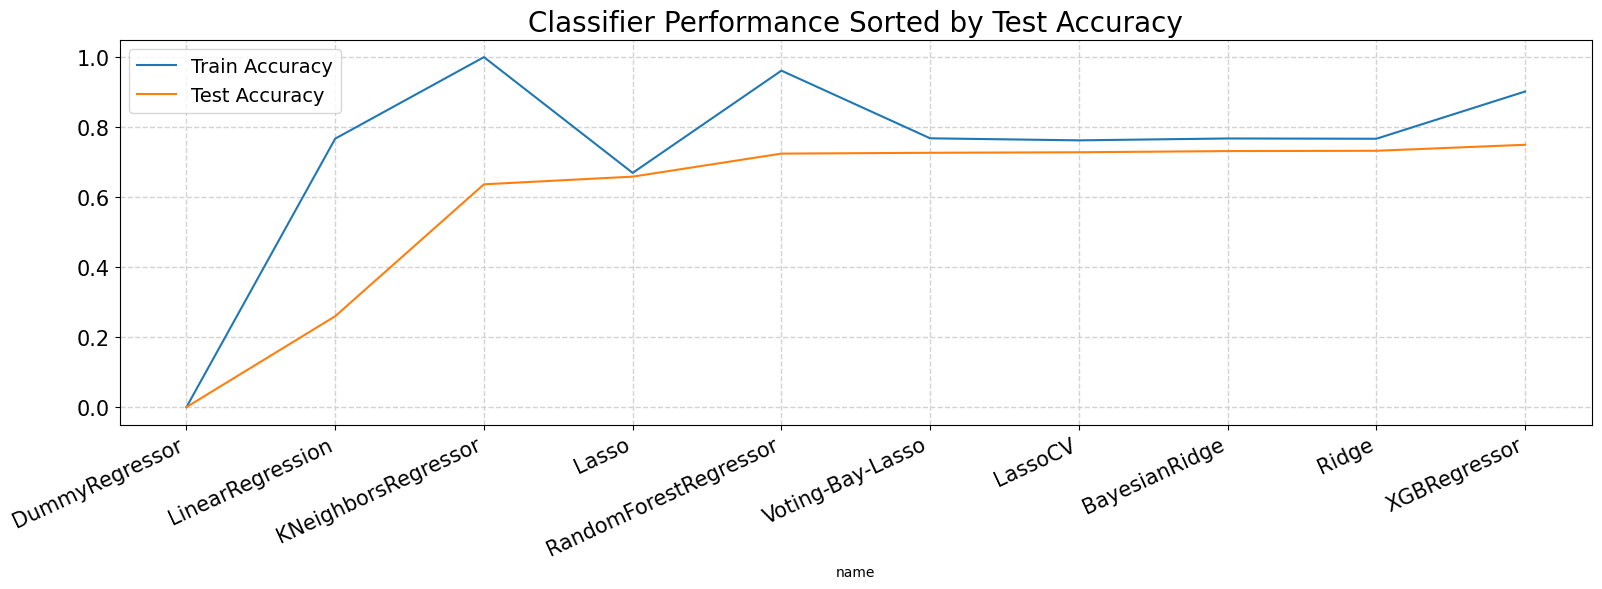

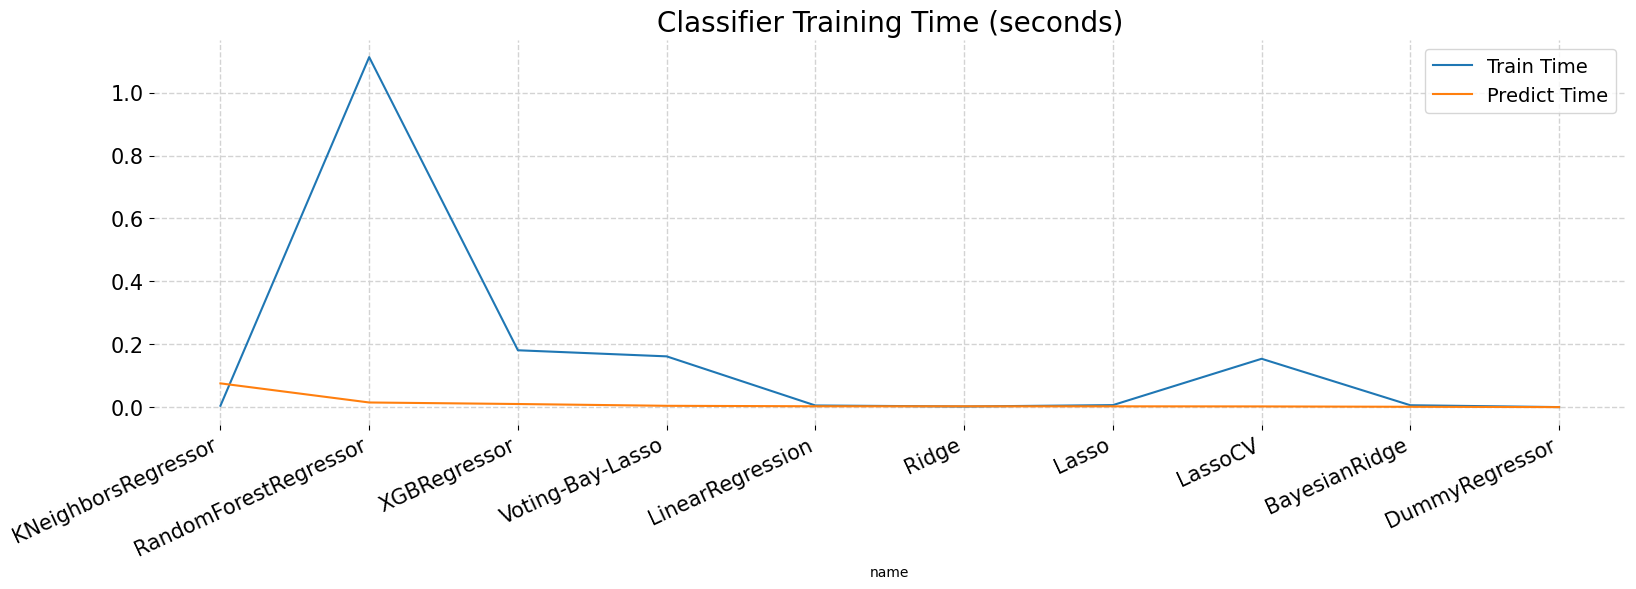

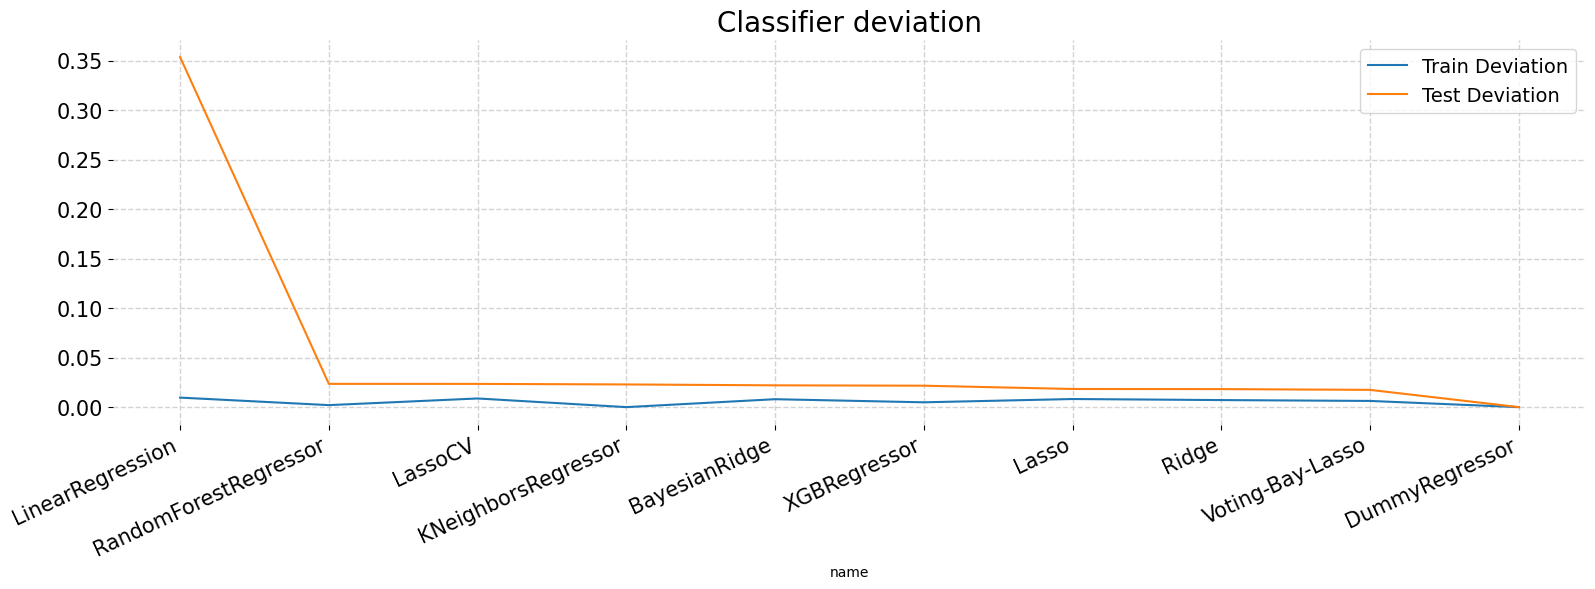

In [21]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
    X = data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    
    start_time = time.time()
    trained_model = model["clf"].fit(X_train, y_train)
    train_time = time.time() - start_time

    
    start_time = time.time()
    y_pred = trained_model.predict(X_test)
    predict_time = time.time() - start_time
    
    test_score = metrics.r2_score(y_test, y_pred)
    test_score = max(test_score, 0)
    
    y_pred = trained_model.predict(X_train)
    train_score = metrics.r2_score(y_train, y_pred)
    train_score = max(train_score, 0)
    
    model_details = {"name": model["name"], "test_accuracy": test_score, "train_accuracy": train_score, "train_time": train_time, "predict_time": predict_time}
    return model_details

models = [
          {"name": "Dummy Regressor", "clf": dummy.DummyRegressor()},
          {"name": "KNN", "clf": KNeighborsRegressor(n_neighbors=10, weights='distance')},
          {"name": "LassoCV", "clf": LassoCV(cv=50)}, 
          {"name": "Lasso", "clf": Lasso(alpha=0.1)},
          {"name": "RandomForestRegressor", "clf": RandomForestRegressor(max_depth=75)},
          {"name": "Ridge", "clf": Ridge(alpha=0.89)}, 
          {"name": "LinearRegression", "clf": LinearRegression()}, 
          {"name": "BayesianRidge", "clf": BayesianRidge()},
          {"name": "Best Model", "clf": best_model}]

for model in list_models*25:
    model_details = train_model(model, data_X[col_num], data_Y[TARGET]) 
    trained_models.append(model_details)


    
# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models).groupby('name').mean()
model_df.sort_values("test_accuracy", inplace=True)
print(model_df["test_accuracy"])
ax = model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
ax.title.set_size(20)
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
#plt.xticks(rotation=90)

model_df.sort_values("predict_time", inplace=True, ascending=False)
ax= model_df[["train_time", "predict_time"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time", "Predict Time"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False)  


model_df = pd.DataFrame(trained_models).groupby('name').std()
model_df.sort_values("test_accuracy", inplace=True, ascending=False)
ax= model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier deviation")
ax.title.set_size(20)
ax.legend(["Train Deviation", "Test Deviation"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False) 

In [22]:
import shap

In [23]:
shap.initjs()

In [24]:
shap_model = BayesianRidge(alpha_init=1, lambda_init=0.1)#LassoCV(cv=5)
shap_model.fit(data_X[col_num], data_Y[TARGET])

explainer = shap.LinearExplainer(shap_model, data_X[col_num], feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

In [25]:
#shap_model = XGBRegressor().fit(data_X[col_num], data_Y[TARGET])

In [26]:
#explainer = shap.Explainer(shap_model, feature_names=col_num)
#shap_values = explainer.shap_values(data_X[col_num])

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=col_num)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


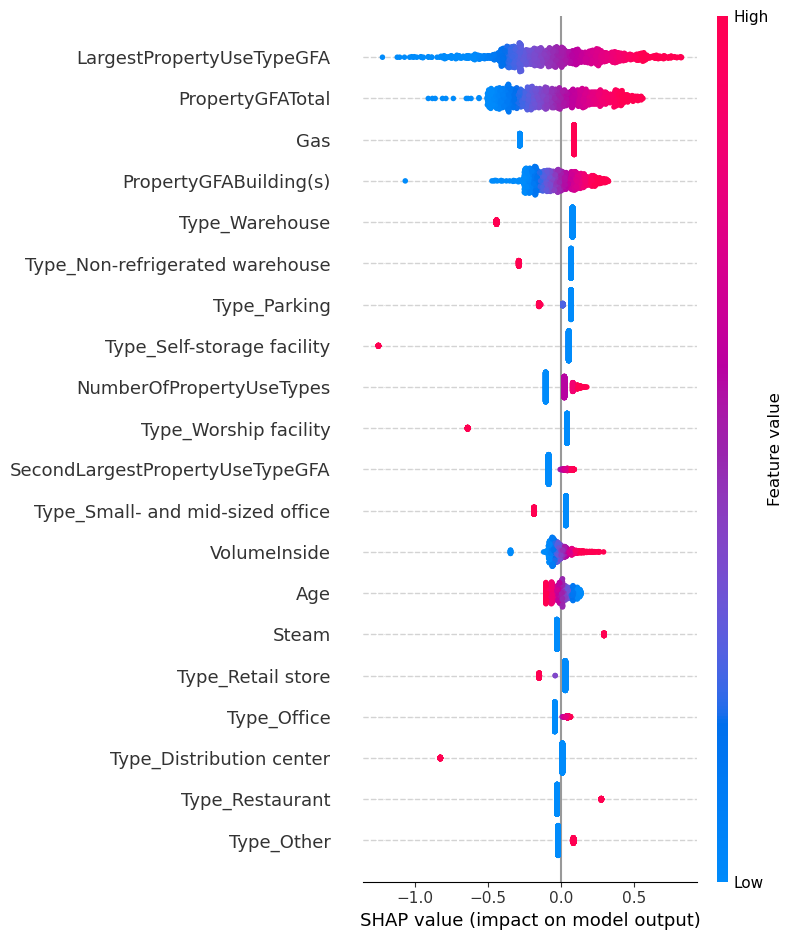

In [28]:
shap.summary_plot(shap_values, data_X[col_num])

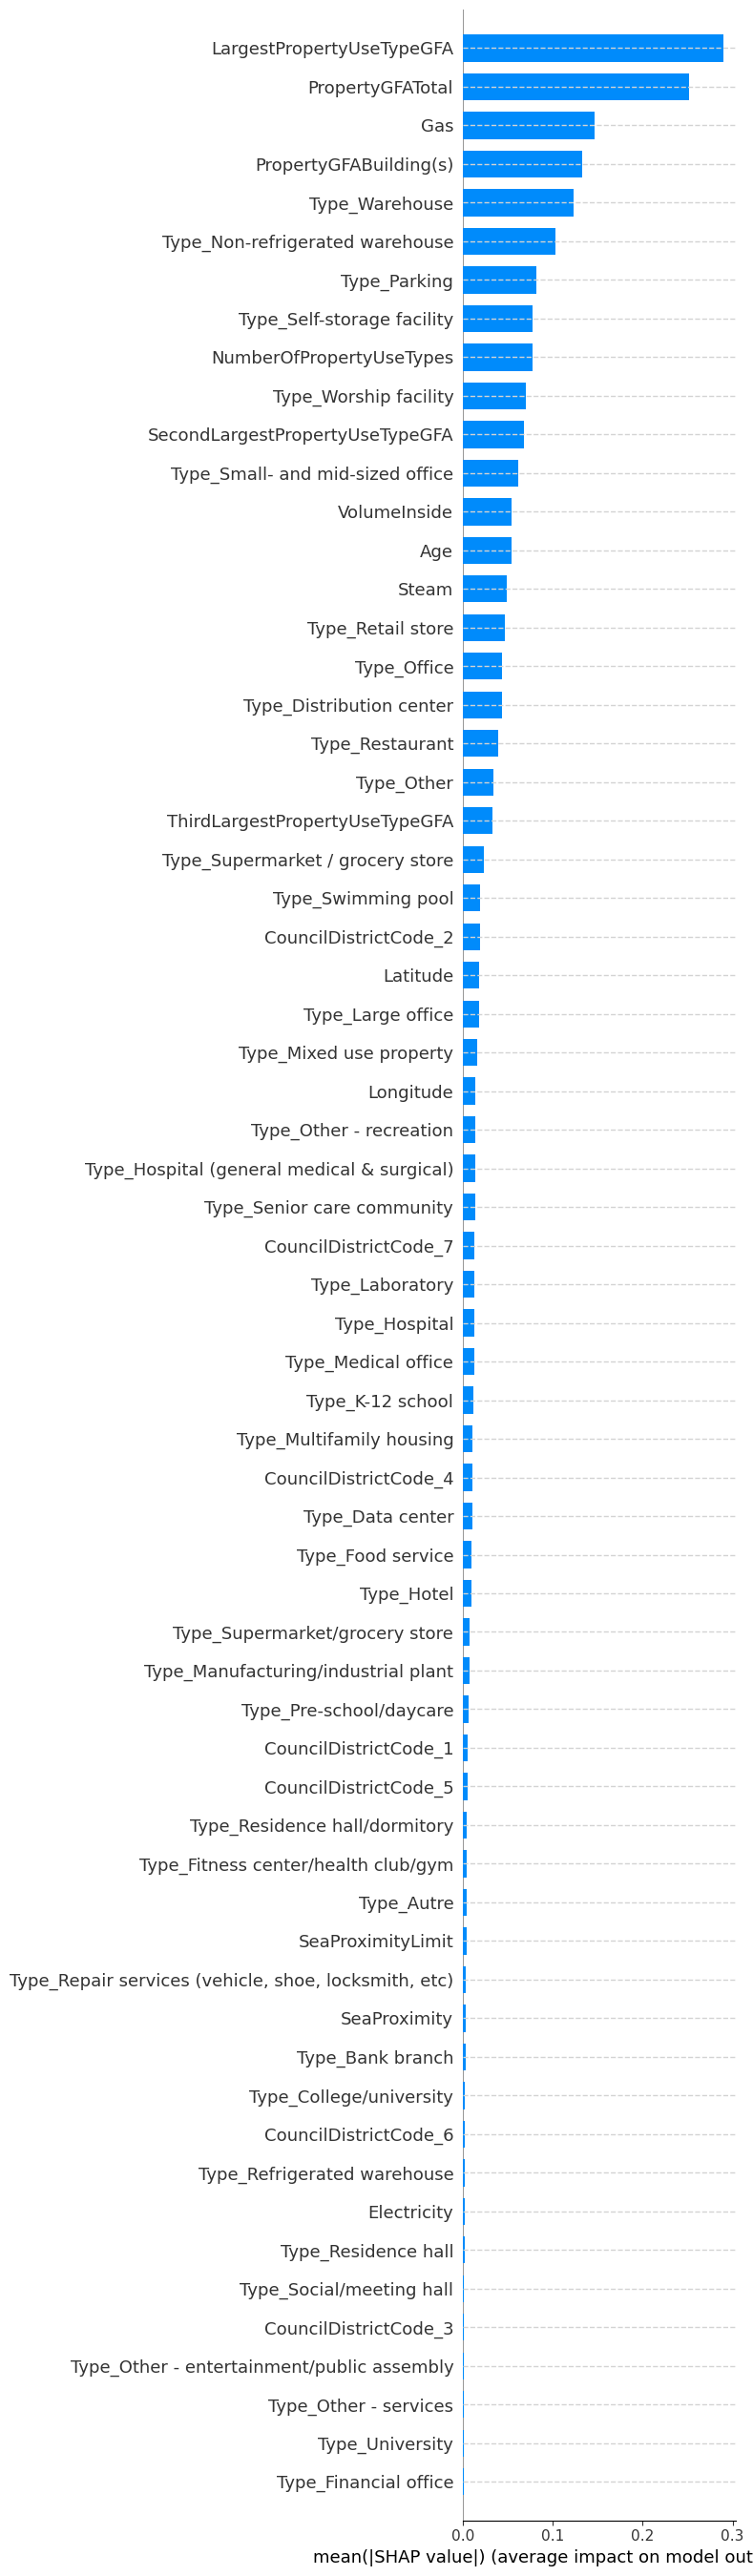

In [29]:
shap.summary_plot(shap_values, data_X[col_num], plot_type="bar", max_display=300)